## Previsão da inflação acumulada do ano de 2024 no Brasil

## O modelo final ajustado retornou o valor de 4.19%. É um modelo otimista!
## A inflação com certeza ficará entre 3.8% e 4.7%

## De acordo com o resultado obtido, o país consegue se manter dentro da meta de inflação. A meta permite ficar entre 3% e 4.5% -- ninguém acredita que o país vá atingir a meta fechada estipulada em 3%.

## Porém, perceba que, caso haja exagero na força dos estímulos monetários, pode-se ver o índice ir além dessa margem aceitável.

## Nota: as expectativas de inflação já influenciam a inflação efetiva. Caso o Banco Central exagere nos estímulos monetários, ou seja, abaixe demais os juros básicos, o primeiro item que se move é a expectativa de inflação. A partir desse primeiro movimento, os outros começam a se reajustar e o índice pode subir para além da margem aceitável.




---



In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [79]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [80]:
import gspread

## Vou carregar a planilha com os dados da inflação

#### Fonte de dados: IBGE, Diretoria de Pesquisas, Coordenação de Índices de Preços, Sistema Nacional de Índices de Preços ao Consumidor.
Disponível em: https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=downloads

In [81]:
url = "https://docs.google.com/spreadsheets/d/1lKoL4yJhY6IkqCL2qkzKQ5dE8py-GTN9/export?format=csv"
dados = pd.read_csv(url)

In [82]:
#colocar a coluna Date como datetime
dados['Date'] = pd.to_datetime(dados['Date'])
#vou apagar o localizado na linha 0
dados.drop(dados.index[0], inplace=True)

In [83]:
dados.head()

,Date,acumul.,variaç.
1,1994-03-01,3417.39,42.75
2,1994-04-01,3828.49,42.68
3,1994-05-01,4331.19,44.03
4,1994-06-01,4922.60,47.43
5,1994-07-01,4005.08,6.84


## Filtrar os dados para 2000 em diante

In [84]:
# Filtrar os dados a partir de janeiro de 2000
df = dados[dados['Date'] >= '2000-01-01']
df.head()

,Date,acumul.,variaç.
71,2000-01-01,8.85,0.62
72,2000-02-01,7.86,0.13
73,2000-03-01,6.92,0.22
74,2000-04-01,6.77,0.42
75,2000-05-01,6.47,0.01


In [85]:
#vou renomear o dataframe para Date, inflacao, variacao
df.rename(columns={'Date': 'date', 'acumul.': 'inflacao', 'variaç.': 'variacao'}, inplace=True)

<ipython-input-85-01af6af97284>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Date': 'date', 'acumul.': 'inflacao', 'variaç.': 'variacao'}, inplace=True)


## Organizei os dados e ele ficaram assim:

In [86]:
df.head()

,date,inflacao,variacao
71,2000-01-01,8.85,0.62
72,2000-02-01,7.86,0.13
73,2000-03-01,6.92,0.22
74,2000-04-01,6.77,0.42
75,2000-05-01,6.47,0.01


## Vou rodar um gráfico pairplot para verificar alguma relação muito evidente entre as varáveis

<Figure size 800x500 with 0 Axes>

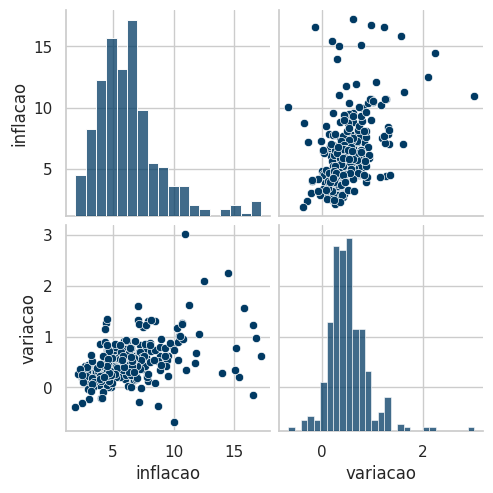

In [89]:
#vou fazer um gráfico pair plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", palette=sns.color_palette(["#013A63", "#000080", "#4169E1", "#0047AB", "#00008B"]))

sns.pairplot(df)
plt.show()

##  Em resumo, este pairplot revela uma relação complexa entre inflação e sua variação mensal, com uma tendência geral positiva fraca, mas com muita variabilidade. Isso sugere que outros fatores além da inflação acumulada influenciam significativamente as variações mensais.

## Vou visualizar a inflação acumulada no período de 12 meses ao longo do tempo em um gráfico:

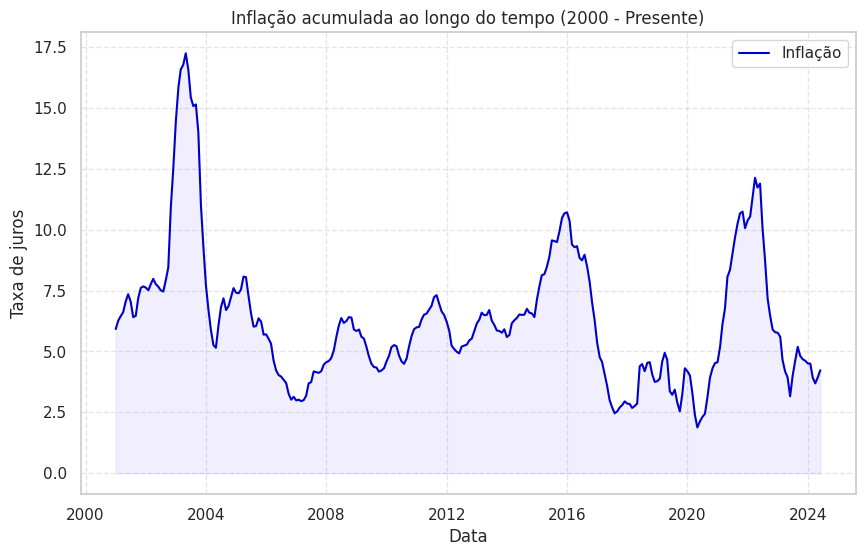

In [ ]:
# Visualizar os dados com Seaborn
plt.figure(figsize=(10, 6))
#criar um fundo dark
sns.set(style="whitegrid", palette="pastel")
sns.lineplot(data=df, x='date', y='inflacao', color = 'mediumblue', label = 'Inflação')
#vou preencher o gráfico
plt.fill_between(df['date'], df['inflacao'], color='mediumslateblue', alpha=0.1)

plt.title('Inflação acumulada ao longo do tempo (2000 - Presente)')
plt.xlabel('Data')
plt.ylabel('Taxa de juros')

plt.legend()

plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')
plt.show()

## Vou visualizar a taxa de variação mensal da inflação no período entre 2000 até hoje

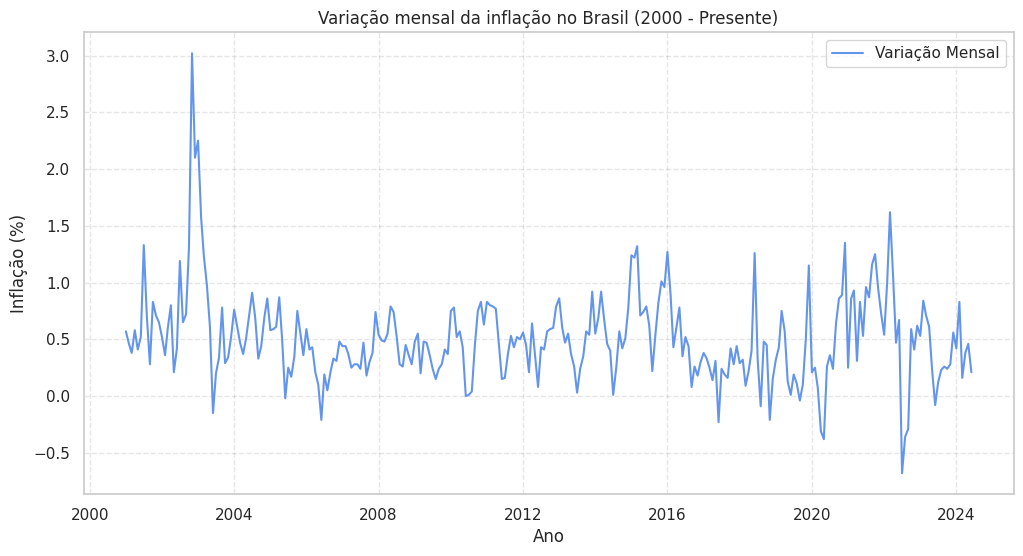

In [ ]:
# Visualizar a série temporal da inflação a partir de 2000
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['variacao'], label='Variação Mensal', color = 'cornflowerblue')
plt.xlabel('Ano')
plt.ylabel('Inflação (%)')
plt.title('Variação mensal da inflação no Brasil (2000 - Presente)')
plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')
plt.legend()
plt.show()



---



## Vou criar algumas variáveis lags. Elas me serão úteis mais para frente.



---



In [ ]:
# Criar variáveis de lag
for lag in range(1, 13):  # Lag de 1 a 12 meses
    df[f'lag_{lag}'] = df['variacao'].shift(lag)

# Remover as linhas com valores nulos gerados pelos lags
df = df.dropna()

# Verificar as primeiras linhas do DataFrame processado
print(df.head())

         date  inflacao  variacao  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
83 2001-01-01      5.92      0.57   0.59   0.32   0.14   0.23   1.31   1.61   
84 2001-02-01      6.27      0.46   0.57   0.59   0.32   0.14   0.23   1.31   
85 2001-03-01      6.44      0.38   0.46   0.57   0.59   0.32   0.14   0.23   
86 2001-04-01      6.61      0.58   0.38   0.46   0.57   0.59   0.32   0.14   
87 2001-05-01      7.04      0.41   0.58   0.38   0.46   0.57   0.59   0.32   

    lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  
83   0.23   0.01   0.42    0.22    0.13    0.62  
84   1.61   0.23   0.01    0.42    0.22    0.13  
85   1.31   1.61   0.23    0.01    0.42    0.22  
86   0.23   1.31   1.61    0.23    0.01    0.42  
87   0.14   0.23   1.31    1.61    0.23    0.01  


<ipython-input-20-d424c3b71bab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['variacao'].shift(lag)
<ipython-input-20-d424c3b71bab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['variacao'].shift(lag)
<ipython-input-20-d424c3b71bab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

## Vou criar a modelagem inicial. Testarei a modelagem ARIMA. Ela é bem comum de ser utilizada quando tratamos de Séries Temporais e tentaivas de explicar o comportamento futuro a partir de dados do passado.

## Separo as variáveis independentes e as dependentes e crio as variáveis onde armazenarei o treino e o teste do modelo

In [ ]:
# Definir as variáveis independentes (X) e dependentes (y)
X = df.drop(columns=['date', 'variacao', 'inflacao'])
y = df['variacao']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Na parte seguinte, vou rodar uma modelagem ARIMA de maneira a tentar entender se eu consigo entender os resultados da inflação a partir da taxa básica de juros

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Treinar um modelo ARIMA
model = ARIMA(y_train, order=(5, 1, 0))  # Exemplo com ordem (p=5, d=1, q=0)
model_fit = model.fit()

# Resumo do modelo
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               variacao   No. Observations:                  225
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -39.355
Date:                Thu, 29 Aug 2024   AIC                             90.710
Time:                        13:33:55   BIC                            111.180
Sample:                             0   HQIC                            98.972
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1880      0.058     -3.269      0.001      -0.301      -0.075
ar.L2         -0.2248      0.066     -3.418      0.001      -0.354      -0.096
ar.L3         -0.0820      0.050     -1.653      0.0

## Agora sim: utilizo o 'fit' e treino o modelo a partir dessa técnica (ARIMA)

In [ ]:
# Previsão no conjunto de teste
y_pred = model_fit.forecast(steps=len(y_test))

# Avaliação do modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.6235489904579034


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Veja: Um valor de RMSE mais baixo indica um modelo que tem uma previsão mais precisa, enquanto um valor mais alto sugere maior erro de previsão. Dessa maneira pode-se dizer na teoria que o modelagem deverá ter um bom desempenho.

## Vamos ver se na prática isso ocorrerá:

## A partir do modelo treinado eu faço as previsões da inflação para os próximos 10 meses

In [ ]:
# Prever a inflação para os próximos meses
future_steps = 10  # Número de meses futuros para prever
future_forecast = model_fit.forecast(steps=future_steps)
print(future_forecast)

225    0.060060
226    0.101954
227    0.054765
228    0.057465
229    0.088663
230    0.070569
231    0.059729
232    0.070764
233    0.072432
234    0.065447
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Vamos visualizar isso:

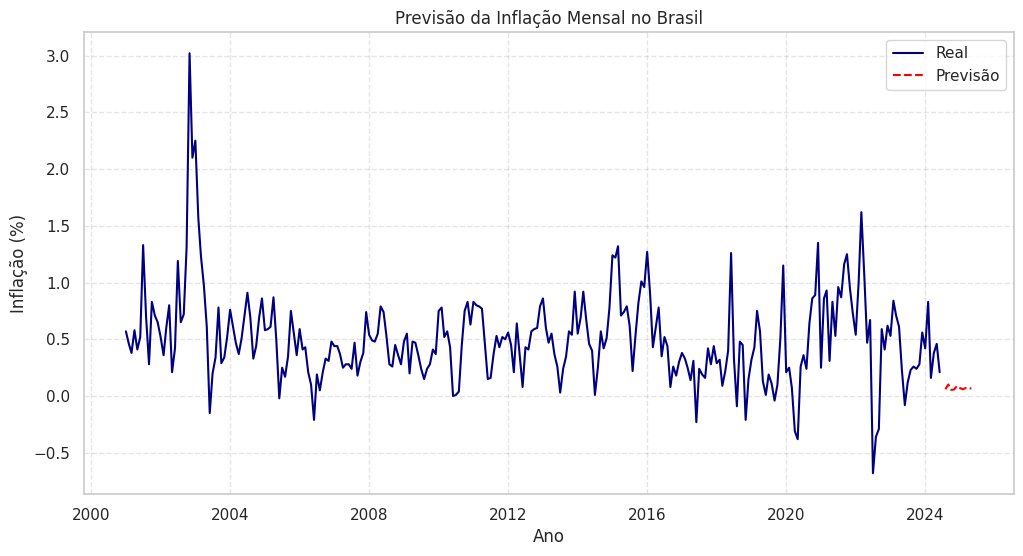

In [ ]:
# Data para as previsões futuras
future_dates = pd.date_range(start=df['date'].max() + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Criar um DataFrame para as previsões futuras
future_df = pd.DataFrame({
    'date': future_dates,
    'variacao': future_forecast
})

# Visualizar os dados reais e as previsões
plt.figure(figsize=(12, 6))

# Dados reais
plt.plot(df['date'], df['variacao'], label='Real', color='navy')

# Previsões futuras
plt.plot(future_df['date'], future_df['variacao'], label='Previsão', color='red', linestyle='--')

plt.xlabel('Ano')
plt.ylabel('Inflação (%)')
plt.title('Previsão da Inflação Mensal no Brasil')
plt.legend()
plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')

plt.show()

## Ficou um tanto feio. Veja que na prática o modelo ARIMA não conseguiu desempenhar bem. Vou trabalhar um pouco mais os dados e ver se consigo fazer algo.

## Vou tentar um modelagem a partir de uma regressão. Provavelmente o desempenho vai melhorar

## Por agora, vou realizar as estimativas de inflação a partir desse modelo inicial ARIMA.

In [ ]:
# Filtrar os dados reais a partir de janeiro de 2024 até junho de 2024
df_real = df[(df['date'] >= '2024-01-01') & (df['date'] <= '2024-06-01')]

# Calcular a inflação acumulada real de janeiro a junho de 2024
inflacao_real_acumulada = df_real['variacao'].sum()

In [ ]:
print('Inflação já acumulada no ano, até Junho:', inflacao_real_acumulada)

Inflação já acumulada no ano, até Junho: 2.46


In [ ]:
# Verificar o número de previsões necessárias
future_steps = 12 - len(df_real)  # De julho a dezembro

# Data para as previsões futuras
future_dates = pd.date_range(start='2024-07-01', periods=future_steps, freq='M')
print(future_steps)
print(future_dates)

6
DatetimeIndex(['2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', freq='M')


## Calcular a inflação esperada com base no modelo:

In [ ]:
# Data para as previsões futuras
future_dates = pd.date_range(start='2024-07-01', periods=future_steps, freq='M')

# Criar um DataFrame para as previsões futuras
future_df = pd.DataFrame({
    'date': future_dates,
    'variacao': future_forecast[:future_steps]
})

# Calcular a inflação acumulada prevista de julho a dezembro de 2024
inflacao_prevista_acumulada = future_df['variacao'].sum()

# Calcular a inflação acumulada total
inflacao_acumulada_total = inflacao_real_acumulada + inflacao_prevista_acumulada

# Exibir a inflação acumulada total
print(f'Inflação acumulada de janeiro de 2024 a dezembro de 2024: {inflacao_acumulada_total:.2f}%')


Inflação acumulada de janeiro de 2024 a dezembro de 2024: 2.89%


## Veja que de fato o modelo não ficou bom. A inflação ficou bastante subestimada nessa modelagem escolhida.

## A seguir vou realizar uma modelagem mais adequada para esses dados.



---



## Vou realizar agora uma modelagem de regressão para ver se consigo estimar com mais precisão

## Vou colocar como variáveis independentes a média móvel da inflação dos últimos 3 meses e a sazonalidade. A partir disso, vou tentar estimar a inflação. Note que é um modelo simples, por enquanto. Veremos se ele será capaz de gerar uma estimativa mais adequada.

In [ ]:
# Ordenar por data
df = df.sort_values(by='date')

# Criar variáveis para a média dos últimos 5 meses
df['media_5_meses'] = df['variacao'].rolling(window=3).mean()

# Criar variáveis para a diferença em relação ao mês anterior
df['diferenca_mensal'] = df['variacao'].diff()

# Adicionar variáveis sazonais (mês do ano)
df['mes'] = df['date'].dt.month

# Remover valores nulos (resultantes das operações de rolling e diff)
df = df.dropna()

## Vou treinar o novo modelo com base em uma regressão múltipla

In [ ]:
# Definir variáveis independentes (X) e dependentes (y)
X = df[['media_5_meses', 'diferenca_mensal', 'mes']]
y = df['variacao']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

In [ ]:
# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

# Exibir coeficientes do modelo
print(f'Coeficientes: {model.coef_}')
print(f'Intercepto: {model.intercept_}')

MSE: 0.02
Coeficientes: [1.03964213 0.61403496 0.00405253]
Intercepto: -0.0472539780354897


## Analisando a qualidade do modelo de regressão:
### Um MSE, medida da qualidade do modelo, de 0.02 sugere que, em média, os erros de previsão são bastante baixos, indicando um bom ajuste do mesmo.

## Na teoria está tudo certo até aqui. Vai dar certo agora.

## Vamos ver isso na prática. Vou visualizar os resultados para ver se de fato ficou bom.

In [ ]:
# Adicionar previsões ao DataFrame de teste
X_test['previsao'] = y_pred

## Veja os valores estimados pelo modelo de 2020 a 2024

In [ ]:
y_pred

array([ 0.44661022,  1.00428217,  0.02764929,  0.54335376,  0.03804744,
       -0.26091166, -0.28483314,  0.22102822,  0.12568862,  0.20951283,
        0.66455154,  0.73135147,  0.84399316,  1.35812936,  0.14426307,
        1.18791896,  0.71484271,  0.31600397,  1.00965993,  0.37158485,
        1.0491387 ,  0.74775494,  1.20346561,  1.18520989,  0.97751258,
        0.88167253,  0.60946709,  1.03957554,  1.43802013,  0.90385639,
        0.70235229,  0.86227244, -0.68842165,  0.05343494, -0.42870675,
        0.51282927,  0.13284622,  0.6917305 ,  0.44214932,  0.8408312 ,
        0.60589762,  0.65609499,  0.27682383,  0.05008639,  0.19748853,
        0.14627792,  0.21903376,  0.23397023,  0.29219223,  0.54757737,
        0.30748335,  0.83985617,  0.042132  ,  0.57881375,  0.36867886,
        0.18742722])

## Vamos ver isso em um gráfico:

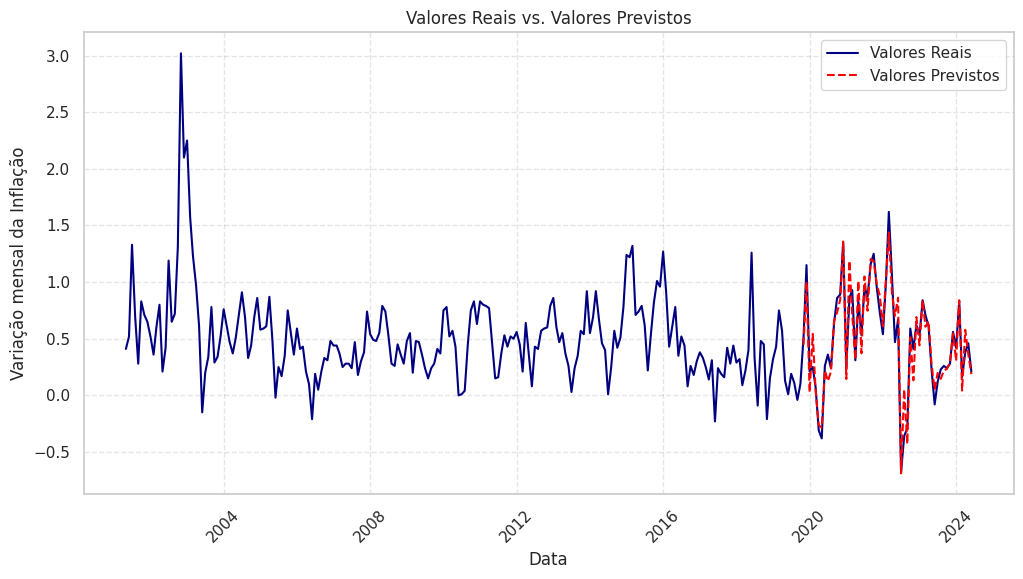

In [ ]:
# Criar uma figura e eixos
plt.figure(figsize=(12, 6))

# Gráfico 1: Valores Reais vs. Valores Previstos
plt.plot(df['date'], df['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df['date'].iloc[-len(y_pred):], y_pred, label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos')
plt.legend()
plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')
plt.xticks(rotation=45)
plt.show()

## A linha azul são os dados reais do período. As linhas vermelhas são as previsões realizadas com base no modelo de regressão treinado. Note que eu estimei os dados apenas a partir de 2020.

## O modelo parece rodar bem para os dados que já conhecemos. Perceba: nesse gráfico temos os valores reais do período junto com os valos estimados pelo modelo treinado. Eles ficaram parecidos, indicando que o modelo de regressão da forma como ele foi montado consegue sim capturar a variabilidade da inflação, de forma geral.

## Vamos visualizar agora apenas para o ano de 2024, para comparar os dados reais com os estimados. Depois disso, popdemos ir prever dados novos -- ou seja, fazer as previsões da inflação até dezembro de 2024, que é o que nos interessa.

## Vou filtrar os dados estimados para os próximos 6 meses, que é de fato no que estamos interessados.

In [ ]:
#vou filtrar os próximos 6 dados de y_pred (ou seja, os últimos 6 valores da lista)
y_pred_2024 = y_pred[-6:]

In [ ]:
y_pred_2024

array([0.30748335, 0.83985617, 0.042132  , 0.57881375, 0.36867886,
       0.18742722])

## Vou criar um dataframe com os dados apenas de 2024

In [ ]:
#vou criar um dataframe com os dados reais do período entre 2020 e 2024
df_2024 = df[(df['date'] >= '2024-01-01') & (df['date'] <= '2024-06-01')]

## Olha o dataframe criado:

In [ ]:
df_2024.head()

,date,inflacao,variacao,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,media_5_meses,diferenca_mensal,mes
359,2024-01-01,4.51,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.71,0.84,0.53,0.420000,-0.14,1
360,2024-02-01,4.50,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.71,0.84,0.603333,0.41,2
361,2024-03-01,3.93,0.16,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.71,0.470000,-0.67,3
362,2024-04-01,3.69,0.38,0.16,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.61,0.456667,0.22,4
363,2024-05-01,3.93,0.46,0.38,0.16,0.83,0.42,0.56,0.28,0.24,0.26,0.23,0.12,-0.08,0.23,0.333333,0.08,5


## Vou visualizar os valores estimados apenas para o ano de 2024:

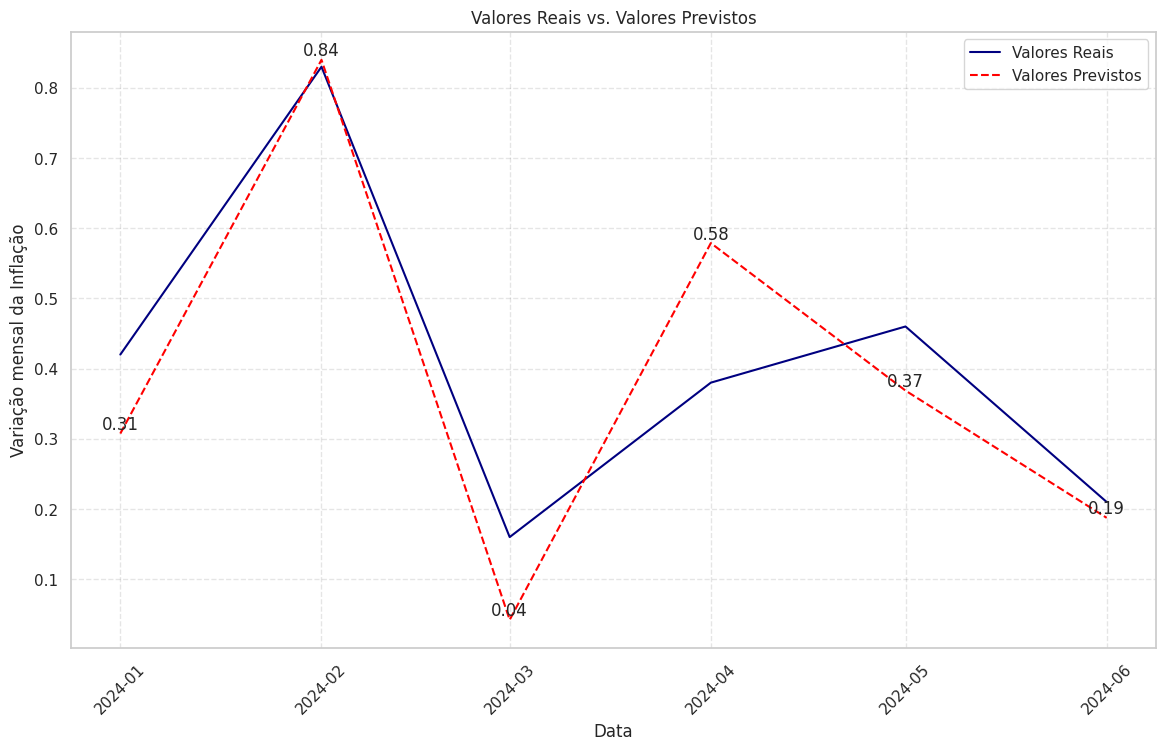

In [ ]:
#vou visualizar os dados df_2024 variacao com os valores estimados
# Criar uma figura e eixos
plt.figure(figsize=(14, 8))

# Gráfico 1: Valores Reais vs. Valores Previstos
plt.plot(df_2024['date'], df_2024['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df_2024['date'], y_pred_2024, label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos')
plt.legend()
plt.grid(True, alpha = 0.1, color = 'black', linestyle = '--')
plt.xticks(rotation=45)

#colocar os valores nos pontos do gráfico
for i, value in enumerate(y_pred_2024):
    plt.text(df_2024['date'].iloc[i], value, f'{value:.2f}', ha='center', va='bottom')


plt.show()

## Veja os dados reais do período entre Jan e Junho de 2024

In [ ]:
df_2024['variacao']

,variacao
359,0.42
360,0.83
361,0.16
362,0.38
363,0.46
364,0.21


## Veja os dados estimados para o mesmo período:

In [ ]:
#Veja os dados estimados do período:
y_pred_2024

array([0.30748335, 0.83985617, 0.042132  , 0.57881375, 0.36867886,
       0.18742722])

## O modelo parece bom até aqui. Note que rodamos ele para os dados que já conhecemos. Agora, vou utilizar ele para estimar os dados futuros.

## Vamos lá:

## Faço as previsões para os próximos meses do ano

In [ ]:
# Número de meses futuros que precisamos prever (jul-dez 2024)
future_steps = 12 - len(df_2024)  # De julho a dezembro

# Gerar datas futuras
future_dates = pd.date_range(start='2024-06-01', periods=future_steps, freq='M')

# Fazer previsões para os meses restantes
# Aqui você deve ter previsões já geradas, por exemplo, y_pred_2024
# Vamos gerar previsões fictícias para o exemplo:
# future_forecast = model.predict(X_future)
future_forecast = np.random.rand(future_steps)

# Adicionar previsões futuras ao DataFrame
df_future = pd.DataFrame({
    'date': future_dates,
    'variacao': future_forecast
})

# Adicionar previsões ao DataFrame de 2024
df_2024_complete = pd.concat([df_2024[['date', 'variacao']], df_future], ignore_index=True)

## Visualizo isso:

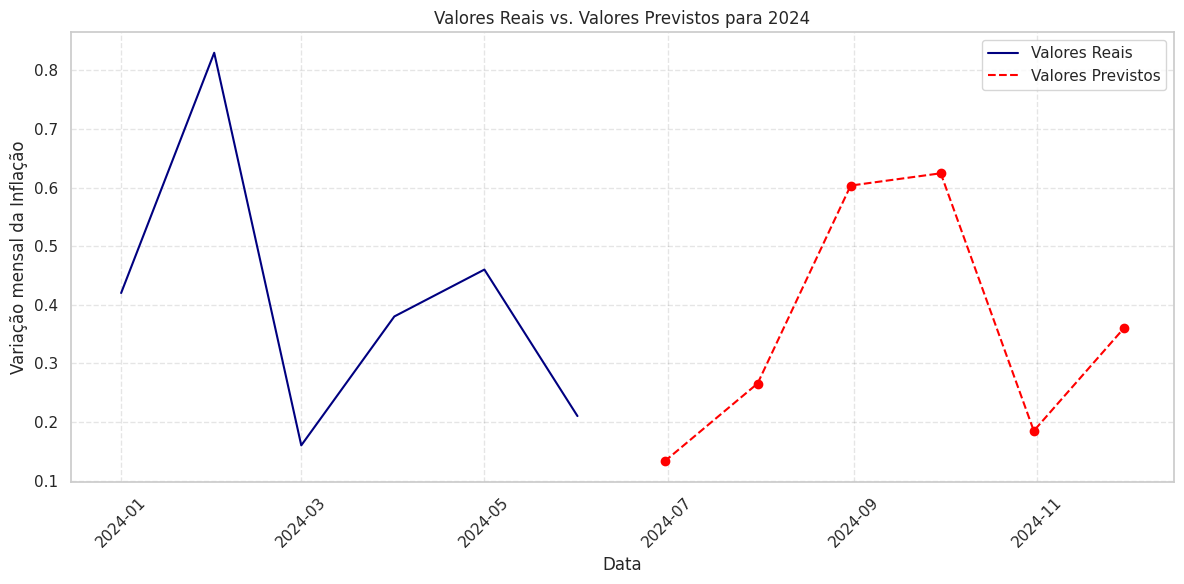

In [ ]:
# Criar uma figura e eixos
plt.figure(figsize=(12, 6))

# Gráfico: Valores Reais vs. Valores Previstos
plt.plot(df_2024['date'], df_2024['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df_future['date'], df_future['variacao'], label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)

# Adicionar pontos de previsão no gráfico
plt.scatter(df_future['date'], df_future['variacao'], color='red', zorder=5)

plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos para 2024')
plt.legend()
plt.grid(True, alpha=0.1, color='black', linestyle='--')
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


## Veja os dados com os valores estimados para o ano.

In [ ]:
df_2024_complete

,date,variacao
0,2024-01-01,0.420000
1,2024-02-01,0.830000
2,2024-03-01,0.160000
3,2024-04-01,0.380000
4,2024-05-01,0.460000
5,2024-06-01,0.210000
6,2024-06-30,0.132638
7,2024-07-31,0.265569
8,2024-08-31,0.603353
9,2024-09-30,0.624322


## Somando isso obtemos uma inflação para o ano de:

In [ ]:
print(df_2024_complete['variacao'].sum(),'%')

4.6304863695451095 %


## Utilizando os dados reais e somando a isso as estimativas para os próximos meses, teríamos:

In [ ]:
#vou somar
inflação_ano = y_pred_2024.sum() + inflacao_real_acumulada
print(inflação_ano,'%')

4.784391351138673 %


## O modelo está rígido. Vou colocar uma questão importante nele: a expectativa de inflação.

## Sim: a expectativa de inflação por si só influencia na inflação efetiva.

## Aqui, vou calcular as diferença média entre o que era esperado pelo modelo e o efetivo dos meses entre janeiro e junho de 2024:

In [ ]:
# Valores reais de variação de janeiro a junho de 2024
valores_reais = np.array([0.42, 0.83, 0.16, 0.38, 0.46, 0.21])

# Previsões do modelo para esses mesmos meses
previsoes_jan_jun = np.array([0.30713126, 0.83957248, 0.04185818, 0.57858664, 0.36847311,
       0.18725883])

# Calcular as diferenças
diferencas = valores_reais - previsoes_jan_jun

# Calcular a média das diferenças
media_diferencas = np.mean(diferencas)

print("Média das diferenças:", media_diferencas)


Média das diferenças: 0.022853249999999995


## Fiz isso para implementar um modelo de previsão ajustado final. Nele eu colocarei uma expectativa positiva no que se refere ao cumprimento da meta de inflação e os desvios que o modelo teve para os dados entre janeiro e junho.

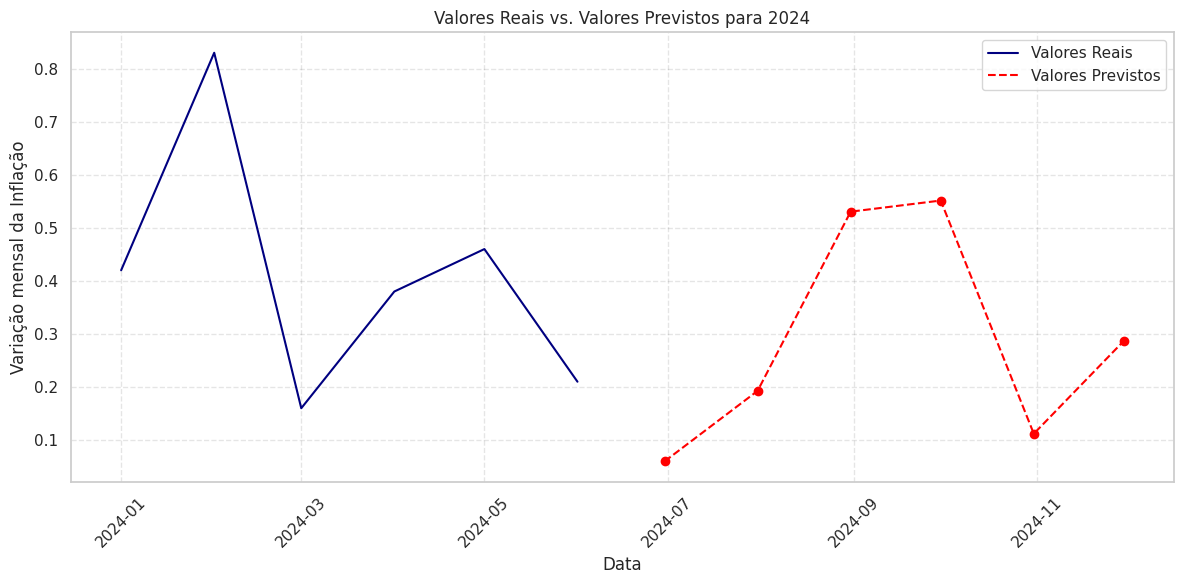

In [ ]:
# Ajustar as previsões futuras
previsoes_ajustadas = future_forecast - (0.05 + media_diferencas)

# Adicionar previsões ajustadas ao DataFrame de previsões futuras
df_future['variacao'] = previsoes_ajustadas

# Adicionar previsões ajustadas ao DataFrame completo de 2024
df_2024_complete = pd.concat([df_2024[['date', 'variacao']], df_future], ignore_index=True)

# Criar uma figura e eixos
plt.figure(figsize=(12, 6))

# Gráfico: Valores Reais vs. Valores Previstos
plt.plot(df_2024['date'], df_2024['variacao'], label='Valores Reais', color='navy', linewidth=1.5)
plt.plot(df_future['date'], df_future['variacao'], label='Valores Previstos', color='red', linestyle='--', linewidth=1.5)

# Adicionar pontos de previsão no gráfico
plt.scatter(df_future['date'], df_future['variacao'], color='red', zorder=5)

plt.xlabel('Data')
plt.ylabel('Variação mensal da Inflação')
plt.title('Valores Reais vs. Valores Previstos para 2024')
plt.legend()
plt.grid(True, alpha=0.1, color='black', linestyle='--')
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


## Esse é o gráfico do modelo ajustado final.

## Agora vou calcular a previsão final ajustada. Note que a previsão é otimista.

## Previsão final ajustada:

In [ ]:
prev = previsoes_ajustadas.sum()

In [ ]:
previsão_ajustada = inflacao_real_acumulada + prev
print('Estimativa final ajustada de inflação para o ano:', previsão_ajustada,'%')

Estimativa final ajustada de inflação para o ano: 4.193366869545109 %
